# Introduction to AI
## Handwritten Digit Recognizer
The goal of this project is give an introduction on how AI - specifically machine learning models work.

We'll do this by building a handwritten digit recognition model  
that's able to classify a 28x28 array of black and white pixels based on the digit contained within

## Prelims
**Tensor**: An array of objects
- Can be an array of tensors
- Images are a 2D tensor of pixel values  
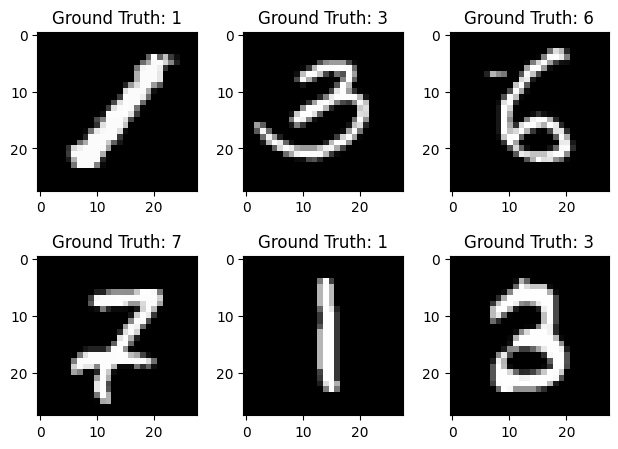

# Step 0: Setup our environment
We will be using a Google Colab environemnt to run this notebook.   
You can access Colab [here](https://colab.research.google.com), or at https://colab.research.google.com

To pull the notebook from github to colab, paste in this repository's URL into the GitHub section of the "Open notebook" menu.  
Hitting enter should pull and load the notebook automatically.

# Step 1: Load the data
Torch has a bunch of datasets built in for machine learning,  
with topics ranging from image classification to optical flow.  
A full list can be found here: https://docs.pytorch.org/vision/stable/datasets.html

We'll use torch and torchvision's builtin image handling functions  
for our image handling outside the model, and matplotlib to visualize data.

In [1]:
import torch # Data structures for multi-dimensional tensors & operations over those tensors
import torchvision # Popular datasets, model architectures, & common image transformations for CV

In [ ]:
# These are hyperparameters, a set of constant settings for our model
n_epochs = 3 # Number of training loops to train our model for
batch_size_train = 64 # Number of examples we train with at once during training
batch_size_test = 1000 # Number of examples we train with at once during testing
learning_rate = 0.01 # How fast the model learns
momentum = 0.5 # Adds intertia to gradient descent
log_interval = 10 # How often to print a status update

torch.backends.cudnn.enabled = False # Disable nondeterministic backend algorithms
random_seed = 4738
torch.manual_seed(random_seed)

## Data Loaders
Datasets can be used directly to train machine learning models,  
but it's usually better to use a data loader.

Data loaders package your dataset with several helpful functions,  
like batching, transformations, enumeration, and more.

We'll be using torch's builtin DataLoader, as it fits our needs off the shelf,  
however it is still extremely useful for custom applications.

In [3]:
ds_transform = transform = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(), # Turn all of the images to tensors
                               ])

# Download all of the training & test data
train_ds = torchvision.datasets.MNIST('data/', train=True, download=True, 
                                     transform=ds_transform)

test_ds = torchvision.datasets.MNIST('data/', train=False, download=True,
                                     transform=ds_transform)


# Build the data loaders for the training & test datasets
train_data_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size_train, shuffle=True
)

test_data_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size_test, shuffle=True
)

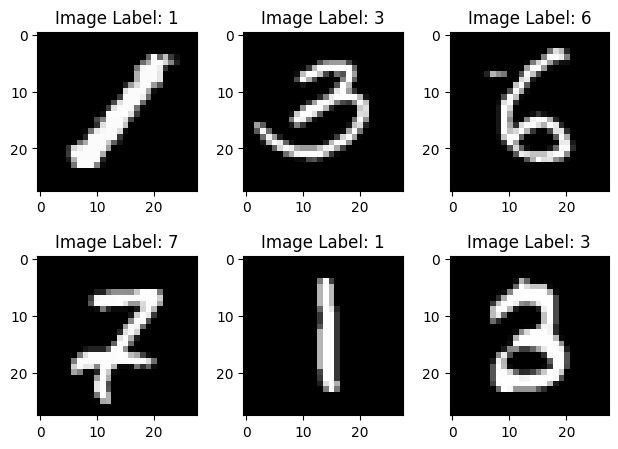

In [4]:
import matplotlib.pyplot as plt

# Load some examples so we can see what we're working with
examples = enumerate(test_data_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Image Label: {example_targets[i]}")

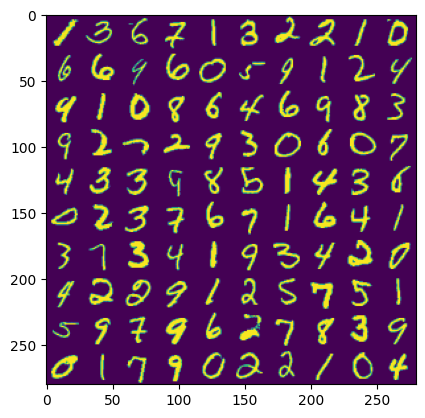

In [5]:
plt.imshow(example_data[:100].reshape(10,10,1,28,28).permute(2,0,3,1,4).reshape(1,280,280)[0]) # For reference, this is what our model sees

# Step 2: Build the neural network
Torch's main draw is the robust machine learning ecosystem.  
The `torch.nn` module contains most (if not all) of the functions  
required to build an effective machine learning model,  
and is used by most large AI companies (OpenAI, Microsoft, Nvidia, etc.)

## The layers and what they mean
Machine learning (ML) networks are made from a series of layers,  
each with a different purpose.

In this project, we'll be using 2D Convolutional layers,  
Dropout layers, and Linear transformation layers.

### Convolutional Layers
Convolutional layers work by sliding a `kernel` over some input,
and calculating the dot product between the kernel and each same-size input.
This resulting output matrix represents the input image after it has been transformed in some way,
and this transformation is defined by what the shape and content of the kernel is.

An example 3x3 Sharpness filter looks like this:
[[-1, -1, -1],
 [-1,  8, -1],
 [-1, -1, -1]]
And when run over an image, will make it look "sharper".

A machine learning model learns what the best kernel values (weights) are,
and the kernel size for a ML model varies depending on the model and application.

### Dropout Layers
Dropout layers are quite simple, as they randomly set some fraction of neuron outputs to zero during training.  
This forces the model to learn more robust features and helps to prevent overfitting
- *Overfitting: When a ML model "memorizes" the dataset instead of learning the relation between input and output.*

### Linear Transformation Layers
Linear transformation layers apply a linear transformation of $y=xA^T+b$, where:  
$x=\text{A learned weight matrix}$  
$A=\text{Some input}$  
$T=\text{A transpose that flips the shape of the input to match the output}$  
$b=\text{A learned bias matrix}$  
*This looks a lot like $y=mx+b$ and that's because it is!*

In [6]:
import torch.nn as nn                # All of our neural network layers that have *learned values*
import torch.nn.functional as funcs  # A set of constant functions that *don't learn*
import torch.optim as optim          # Various optimization algorithms that adjust a model's weights to get a better output


In [7]:
class MnistClassifier(nn.Module):
    def __init__(self, kernel_size = 5):
        super(MnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # Two convolutional layers
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()              # One dropout layer
        self.lin1 = nn.Linear(320, 50)                # Two linear transform layers
        self.lin2 = nn.Linear(50, 10)

    def forward(self, x):                             # A forward pass defines how a model actually gets from A to B
        x = funcs.relu(funcs.max_pool2d(self.conv1(x), 2))
        x = funcs.relu(funcs.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = funcs.relu(self.lin1(x))
        x = funcs.dropout(x, training=self.training)
        x = self.lin2(x)
        return funcs.log_softmax(x)

network = MnistClassifier()
network
    

MnistClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (lin1): Linear(in_features=320, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) # Stochastic gradient descent
# Stochastic       -> A random subset of the model instead of the whole thing (makes training faster)
# Gradient descent -> An algorithm that finds the best way to tune the model to lower the loss

In [9]:
# Some arrays to contain data generated during training
train_losses = []
train_counter = []
test_losses = []
# test_counter = []
test_counter = [i * len(train_data_loader.dataset) for i in range(n_epochs + 1)]

## How training works
1. First we need to set the model to "training mode" with `network.train()`  
   - This enables dropout layers and normalizes batches for training
2. Then we can have the model generate an output for the first part of the dataset.  
   - We need something to evaluate the model on
3. We calculate the loss by finding the difference between the output and the target
   - This is the measure of "how wrong" our model is
4. Perform a backward pass on the model to find what parameters need to be tuned and in which direction (positive/negative)
   - As the model runs in training mode, it stores a computation graph that we can reverse for this
5. Run the optimizer to apply these changes to the model
   - Remember, our SGD optimizer applies some random part of these changes
   - Some changes may not be correct! Often we see the loss jump up before going back down
6. Repeat this process several times (epochs) over our entire dataset so we get loss as low as possible

In [10]:
def train(epoch):
    network.train() # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_data_loader):
        optimizer.zero_grad()                 # Clear old gradients so we have a blank slate for this loop
        output = network(data)                # Generate outputs for a given input
        loss = funcs.nll_loss(output, target) # Calculate loss between output and target
        loss.backward()                       # Perform a backward pass to find what needs to be changed
        optimizer.step()                      # Apply those changes to the model

        # This block gives us some diagnostic information so we can see what is happening during and after training
        if batch_idx % log_interval == 0:
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_data_loader.dataset),
                    100. * batch_idx / len(train_data_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_data_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')       # We can store the internal state of the model to load for later training
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

## Testing the model
Testing the model on data it hasn't seen before is important! If the model overfits (memorizes the training DS),  
we'll see a large gap between training loss and test loss, but if they remain similar we know the model generalized well

In [11]:
def test():
    network.eval() # Swap the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad(): # Since we're evaluating the model, we don't need to store the gradients and we can speed up this process
        for data, target in test_data_loader:
            output = network(data)                                                   
            test_loss += funcs.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_data_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_data_loader.dataset),
        100. * correct / len(test_data_loader.dataset)))
test()

C:\Users\awebb\AppData\Local\Temp\ipykernel_34696\2621471198.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return funcs.log_softmax(x)
c:\Users\awebb\Documents\Work\Advanced Computing\BuilderTrack\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3072, Accuracy: 970/10000 (10%)



In [12]:
test() # Since we have 10 classes, a fresh & random model should get 1/10 guesses correct -> ~10% accuracy
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\awebb\AppData\Local\Temp\ipykernel_34696\2621471198.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return funcs.log_softmax(x)



Test set: Avg. loss: 2.3072, Accuracy: 970/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331411
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.289619
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.273920
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.240717
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.133868
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.983854
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.818778
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.377136
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.403412
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.966767
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.825019
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.819168
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.673159
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.889307
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.570117
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.764408
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.469002
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.516879
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.408487

T

4 5


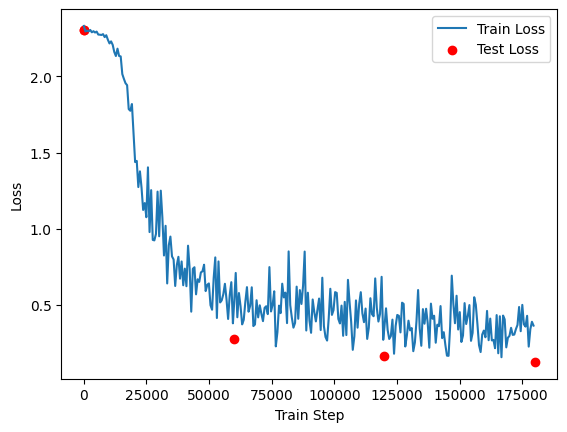

In [13]:
plt.plot(train_counter, train_losses)

# Align test_counter with test_losses length to avoid dimension mismatch
test_x = test_counter
if len(test_losses) != len(test_counter):
    if len(test_losses) > len(test_counter):
        test_x = [0] * (len(test_losses) - len(test_counter)) + test_counter
    else:
        test_x = test_counter[:len(test_losses)]

plt.scatter(test_x, test_losses, c='red')
print(len(test_counter), len(test_losses))
# plt.scatter(test_counter, test_losses, c='red')

plt.xlabel('Train Step')
plt.ylabel('Loss')

plt.legend(['Train Loss', 'Test Loss'])

C:\Users\awebb\AppData\Local\Temp\ipykernel_34696\2621471198.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return funcs.log_softmax(x)


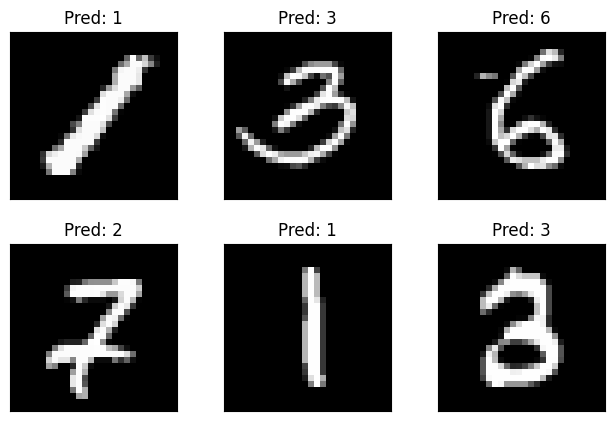

In [14]:
with torch.no_grad():
    output = network(example_data) # This gives us a prediction from our newly trained model
    
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(f"Pred: {output.data.max(1, keepdim=True)[1][i].item()}")
    plt.xticks([])
    plt.yticks([])

## Continuing Training
We may find that our model doesn't quite have the accuracy we want on hard to classify inputs
- An example is the 7 in the bottom left being classified as a 2

We saved the state dictionary and optimizer of our model before, so we can load them both back up and continue their training

In [15]:
# Instantiate new copies of our model and optimizer
continued_network = MnistClassifier()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [16]:
# Load the state dict from the saved files from earlier
network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [17]:
# We train the model over our dataset another 6 times
additional_epochs = 6
for i in range(n_epochs, n_epochs + additional_epochs):
    test_counter.append(i * len(train_data_loader.dataset))
    train(i)
    test()


C:\Users\awebb\AppData\Local\Temp\ipykernel_34696\2621471198.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return funcs.log_softmax(x)


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.293362
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.198252
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.336330
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.332424
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.380329
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.382917
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.343962
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.334368
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.339959
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.259489
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.290950
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.342452
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.721676
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.201700
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.584633
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.383821
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.346008
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.211743
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.242195

Test set: Avg. loss: 0.1074, Accuracy: 9658/10000 (97%)

T

C:\Users\awebb\AppData\Local\Temp\ipykernel_34696\2621471198.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return funcs.log_softmax(x)


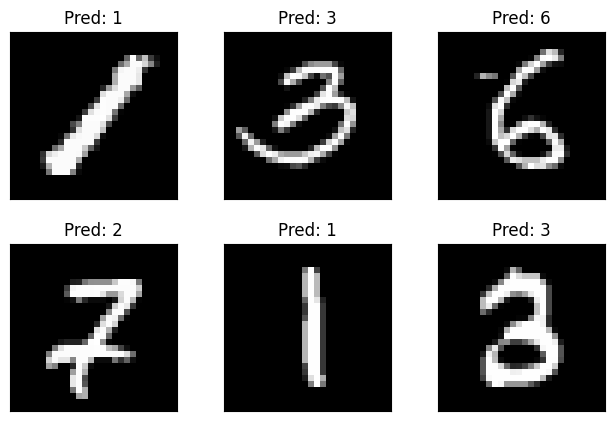

In [18]:
# Let's run the display again and see if that 7 is classified correctly
with torch.no_grad():
    output = network(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(f"Pred: {output.data.max(1, keepdim=True)[1][i].item()}")
    plt.xticks([])
    plt.yticks([])

# Next steps:
Now that you all have a model, run the below cell to export your model as a .onnx file.
This will let you navigate to [this webiste](https://faraday-dot-py.github.io/cpp-ac-mnist-online/) and upload it there.  
Write some digits down and take pictures of them for the model to classify.

### Interesting things to explore:
*Does your model work when deployed to an application?*  
*Can you confuse your model by writing strangely?*  
*What factors effect your model's confidence in its predictions?*  

In [19]:
!pip install --upgrade onnx onnxscript


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
continued_network = MnistClassifier()

network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

example_input = (torch.randn(1, 1, 28, 28))

onnx_program = torch.onnx.export(continued_network, example_input, dynamo=True)

onnx_program.save("results/digit_classifier.onnx")

[torch.onnx] Obtain model graph for `MnistClassifier([...]` with `torch.export.export(..., strict=False)`...


c:\Users\awebb\Documents\Work\Advanced Computing\BuilderTrack\Lib\site-packages\torch\_export\non_strict_utils.py:1066: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


[torch.onnx] Obtain model graph for `MnistClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


# For iPhone Users:
iPhone security measures prevent users from downloading unknown file types. 
Run the below cell to change the file type from .onnx to .txt, which will let you download the model to your phone.

In [21]:
import shutil
shutil.copy('results/digit_classifier.onnx', 'results/digit_classifier.txt')

'results/digit_classifier.txt'